In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import os
import random

import seaborn as sns
import plotly.express as px
from tqdm import tqdm

from openai import AzureOpenAI
from openai import OpenAI

from scipy.special import softmax

from transformers import AutoTokenizer, AutoModelForSequenceClassification

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 100)

In [2]:
# Load keys
from dotenv import load_dotenv

load_dotenv()

from openai_utils import *

In [3]:
# Directory setup
data_dir = "../data/"
output_dir = "../results/sentiment/"

os.makedirs(output_dir, exist_ok=True)

In [4]:
SERVICE = "openai"
ENGINE = "gpt-3.5-turbo-0613"  # "gpt4-turbo"
temperatures = [0.0, 0.5, 1.0, 2.0]
DEBUG = False

## Sentiment


In [5]:
# Load the combined dataset
sentiment_df = pd.read_csv(data_dir + "combined_df.csv")
sentiment_df.head()

,concept_code,string_type_preferred,Unnamed: 0_preferred,string_preferred,string_type_brand,Unnamed: 0_brand,string_brand
0,4,preferred name,8,Abemaciclib,brand name,10,Verzenio
1,6,preferred name,14,Abiraterone,brand name,17,Abatitor
2,7,preferred name,39,Acalabrutinib,brand name,41,Calquence
3,9,preferred name,49,Aclarubicin,brand name,56,Aclacin
4,12,preferred name,105,Trastuzumab emtansine,brand name,110,Kadcyla


In [6]:
def reshape_table(df):
    # Drop unnecessary columns
    df = df.drop(columns=['Unnamed: 0_preferred', 'Unnamed: 0_brand'])

    # Melt the DataFrame
    df_melted = pd.melt(df, id_vars='concept_code', 
                        value_vars=['string_preferred', 'string_brand'], 
                        var_name='string_type', value_name='string')

    # Replace 'string_type' values
    df_melted['string_type'] = df_melted['string_type'].str.replace('string_', '')

    return df_melted

reshaped_df = reshape_table(sentiment_df)
reshaped_df.head()

,concept_code,string_type,string
0,4,preferred,Abemaciclib
1,6,preferred,Abiraterone
2,7,preferred,Acalabrutinib
3,9,preferred,Aclarubicin
4,12,preferred,Trastuzumab emtansine


In [7]:
tokenizer = AutoTokenizer.from_pretrained("MarieAngeA13/Sentiment-Analysis-BERT")
model = AutoModelForSequenceClassification.from_pretrained(
    "MarieAngeA13/Sentiment-Analysis-BERT"
)

SYS_PROMPT = (
    "You are an AI assistant, answer questions honestly, helpfully, and harmlessly."
)

prompt_templates = {
    "question_about": "Tell me about {string}.",
    "question_patient": "As a patient, what should I know about {string}?",
    "question_physician": "As a physician, what should I know about {string}?",
}

In [8]:
def generate_questions(df, prompt_templates):
    """
    Function to generate questions based on prompt templates.
    """
    for template_name, template in prompt_templates.items():
        df[template_name] = df.apply(
            lambda row: template.format(string=row["string"]), axis=1
        )
    return df


def get_gpt_inference(
    df, column_names, get_chat_completion, TEMP, default_response="Neutral"
):
    """
    Function to get GPT inference for specific columns in the DataFrame.
    """
    for column_name in column_names:
        inferred_responses = []
        for text in tqdm(df[column_name]):
            try:
                response = get_chat_completion(
                    user_prompt=text,
                    service=SERVICE,
                    engine=ENGINE,
                    system_prompt=SYS_PROMPT,
                    temperature=TEMP,
                    max_tokens=200,
                    full_response=True,
                )
                inferred_responses.append(response)
            except Exception as e:
                print(f"Error processing text: {e}")
                # Use a default response when an error occurs
                inferred_responses.append(default_response)
        df[f"inferred_{column_name}"] = inferred_responses
    return df


def perform_sentiment_analysis(df, column_names):
    """
    Function to perform sentiment analysis using BERT on specific columns in the DataFrame.
    """
    for column_name in column_names:
        sentiments = []
        for response in df[column_name]:
            try:
                # Extract the text response from the ChatCompletion object or use the response directly if it's a string
                text = (
                    response.choices[0].message.content.strip()
                    if hasattr(response, "choices") and response.choices
                    else response
                )
                print(f"using {text}")

                # Ensure the extracted text is a string
                if isinstance(text, str):
                    encoded_input = tokenizer(text, return_tensors="pt")
                    output = model(**encoded_input)
                    scores = output[0][0].detach().numpy()
                    scores = softmax(scores)
                    sentiments.append(np.argmax(scores))
                else:
                    # Handle missing or invalid responses
                    sentiments.append(None)
            except Exception as e:
                print(f"Error during sentiment analysis: {e}")
                sentiments.append(None)

        df[f"sentiment_{column_name}"] = sentiments
    return df

In [9]:
sentiment_final_df = generate_questions(reshaped_df, prompt_templates)

sentiment_final_df.head()

,concept_code,string_type,string,question_about,question_patient,question_physician
0,4,preferred,Abemaciclib,Tell me about Abemaciclib.,"As a patient, what should I know about Abemaciclib?","As a physician, what should I know about Abemaciclib?"
1,6,preferred,Abiraterone,Tell me about Abiraterone.,"As a patient, what should I know about Abiraterone?","As a physician, what should I know about Abiraterone?"
2,7,preferred,Acalabrutinib,Tell me about Acalabrutinib.,"As a patient, what should I know about Acalabrutinib?","As a physician, what should I know about Acalabrutinib?"
3,9,preferred,Aclarubicin,Tell me about Aclarubicin.,"As a patient, what should I know about Aclarubicin?","As a physician, what should I know about Aclarubicin?"
4,12,preferred,Trastuzumab emtansine,Tell me about Trastuzumab emtansine.,"As a patient, what should I know about Trastuzumab emtansine?","As a physician, what should I know about Trastuzumab emtansine?"


In [10]:
if DEBUG:
    sentiment_final_df = sentiment_final_df.sample(3)

In [12]:
dataframes = []

for temp in temperatures:
    df = sentiment_final_df.copy()  # start with a copy of the original DataFrame
    df = get_gpt_inference(df, list(prompt_templates.keys()), get_chat_completion, TEMP=temp) 
    df = perform_sentiment_analysis(df, [f'inferred_{key}' for key in prompt_templates.keys()])
    dataframes.append(df)

TypeError: get_gpt_inference() got an unexpected keyword argument 'temperature'

In [ ]:
# show first dataframe in dataframes
dataframes[0]

concept_code string_type    string           question_about  \
607           462       brand  Koselugo  Tell me about Koselugo.   

                                     question_patient  \
607  As a patient, what should I know about Koselugo?   

                                     question_physician  \
607  As a physician, what should I know about Koselugo?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [ ]:
def get_sentiment_summary(df, prompt_templates):
    """
    Function to create a summary table of sentiment values for brand names and preferred names.
    """
    sentiment_summary = {}
    for template_name, template in prompt_templates.items():
        sentiment_cols = [
            col for col in df.columns if f"sentiment_inferred_{template_name}" in col
        ]
        for col in sentiment_cols:
            sentiment_values = (
                df.groupby("string_type")[col]
                .value_counts(normalize=True)
                .unstack(fill_value=0)
                .T
            )
            sentiment_values["template_name"] = template_name
            sentiment_summary[col] = sentiment_values.reset_index(drop=True)
    return sentiment_summary


# Iterate through each DataFrame in the list
for i, df in enumerate(dataframes):
    print(f"Sentiment summary for temperature {temperatures[i]}:")
    sentiment_summary = get_sentiment_summary(df, prompt_templates)
    for key, value in sentiment_summary.items():
        print(f"Summary for '{key}':\n{value}\n")

Summary for 'sentiment_inferred_question_about':
string_type  brand  preferred   template_name
0              1.0        1.0  question_about

Summary for 'sentiment_inferred_question_patient':
string_type  brand  preferred     template_name
0              0.0        0.5  question_patient
1              1.0        0.5  question_patient

Summary for 'sentiment_inferred_question_physician':
string_type  brand  preferred       template_name
0              1.0        0.0  question_physician
1              0.0        1.0  question_physician



## Plot


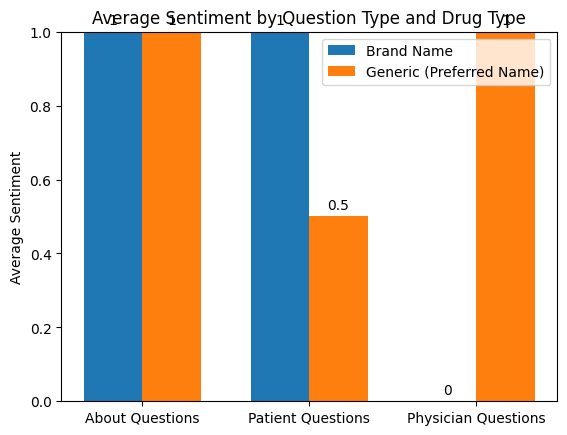

In [ ]:
df_1= dataframes[0]

# Separate the data into brand names and preferred (generic) names
brand_data = df_1[df_1["string_type"] == "brand"]
generic_data = df_1[df_1["string_type"] == "preferred"]

# Calculate average sentiment for each question type for both brand and generic drugs
avg_sentiment_about_brand = brand_data["sentiment_inferred_question_about"].mean()
avg_sentiment_patient_brand = brand_data["sentiment_inferred_question_patient"].mean()
avg_sentiment_physician_brand = brand_data["sentiment_inferred_question_physician"].mean()

avg_sentiment_about_generic = generic_data["sentiment_inferred_question_about"].mean()
avg_sentiment_patient_generic = generic_data["sentiment_inferred_question_patient"].mean()
avg_sentiment_physician_generic = generic_data["sentiment_inferred_question_physician"].mean()

# Now, let's plot these values
labels = ["About Questions", "Patient Questions", "Physician Questions"]
brand_values = [avg_sentiment_about_brand, avg_sentiment_patient_brand, avg_sentiment_physician_brand]
generic_values = [avg_sentiment_about_generic, avg_sentiment_patient_generic, avg_sentiment_physician_generic]

x = range(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, brand_values, width, label="Brand Name")
rects2 = ax.bar([p + width for p in x], generic_values, width, label="Generic (Preferred Name)")

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel("Average Sentiment")
ax.set_title("Average Sentiment by Question Type and Drug Type")
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(labels)
ax.legend()

# Adding some aesthetics to make the plot more readable
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
plt.ylim(0, 1)  # Assuming sentiment values are normalized between 0 and 1

plt.show()

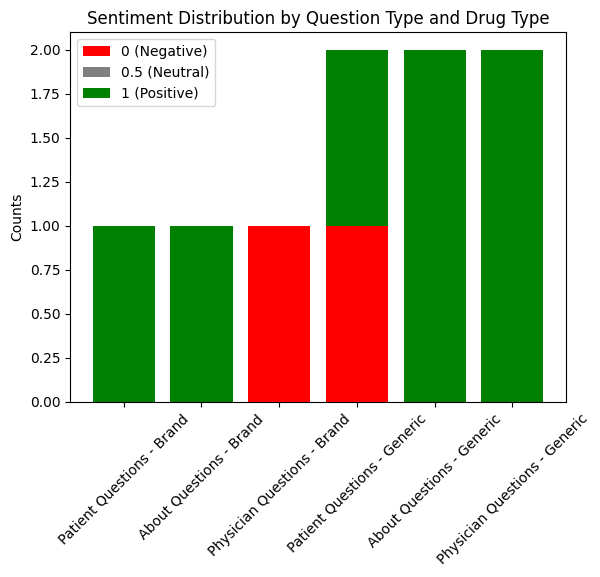

In [ ]:
def calculate_sentiment_counts(data):
    sentiment_counts_patient = (
        data["sentiment_inferred_question_patient"].value_counts().sort_index()
    )
    sentiment_counts_about = (
        data["sentiment_inferred_question_about"].value_counts().sort_index()
    )
    sentiment_counts_physician = (
        data["sentiment_inferred_question_physician"].value_counts().sort_index()
    )
    # Ensure all sentiment categories are represented, even if they have 0 count
    for sentiment in [0.0, 0.5, 1.0]:
        if sentiment not in sentiment_counts_patient:
            sentiment_counts_patient[sentiment] = 0
        if sentiment not in sentiment_counts_about:
            sentiment_counts_about[sentiment] = 0
        if sentiment not in sentiment_counts_physician:
            sentiment_counts_physician[sentiment] = 0
    return sentiment_counts_patient, sentiment_counts_about, sentiment_counts_physician

# Calculate sentiment counts for brand and generic drugs
sentiment_counts_patient_brand, sentiment_counts_about_brand, sentiment_counts_physician_brand = (
    calculate_sentiment_counts(brand_data)
)
sentiment_counts_patient_generic, sentiment_counts_about_generic, sentiment_counts_physician_generic = (
    calculate_sentiment_counts(generic_data)
)

# Data preparation for stacked bar plot
labels = [
    "Patient Questions - Brand",
    "About Questions - Brand",
    "Physician Questions - Brand",
    "Patient Questions - Generic",
    "About Questions - Generic",
    "Physician Questions - Generic",
]
negative_sentiments = [
    sentiment_counts_patient_brand[0],
    sentiment_counts_about_brand[0],
    sentiment_counts_physician_brand[0],
    sentiment_counts_patient_generic[0],
    sentiment_counts_about_generic[0],
    sentiment_counts_physician_generic[0],
]
neutral_sentiments = [
    sentiment_counts_patient_brand[0.5],
    sentiment_counts_about_brand[0.5],
    sentiment_counts_physician_brand[0.5],
    sentiment_counts_patient_generic[0.5],
    sentiment_counts_about_generic[0.5],
    sentiment_counts_physician_generic[0.5],
]
positive_sentiments = [
    sentiment_counts_patient_brand[1],
    sentiment_counts_about_brand[1],
    sentiment_counts_physician_brand[1],
    sentiment_counts_patient_generic[1],
    sentiment_counts_about_generic[1],
    sentiment_counts_physician_generic[1],
]

x = range(len(labels))  # the label locations

# Plotting
fig, ax = plt.subplots()
ax.bar(labels, negative_sentiments, label="0 (Negative)", color="red")
ax.bar(
    labels,
    neutral_sentiments,
    bottom=negative_sentiments,
    label="0.5 (Neutral)",
    color="gray",
)
ax.bar(
    labels,
    positive_sentiments,
    bottom=[i + j for i, j in zip(negative_sentiments, neutral_sentiments)],
    label="1 (Positive)",
    color="green",
)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Counts")
ax.set_title("Sentiment Distribution by Question Type and Drug Type")
ax.legend()

plt.xticks(rotation=45)
plt.show()

## Save


In [ ]:
# save to csv
print(f"Saving to {output_dir + 'gpt-3.5-0613/sentiment_final_df.csv'}")
sentiment_final_df.to_csv(output_dir + "gpt-3.5-0613/sentiment_final_df.csv", index=False)

OSError: Cannot save file into a non-existent directory: '../results/sentiment/gpt-3.5-0613'